In [1]:
# 107303538_1111_hw9_2

In [2]:
import torch
import torch.nn as nn
import numpy as np

數據轉tensor，已知t_c 未知t_u

In [3]:
t_c = [0.273, 0.325, 0.354, 0.378, 0.431] # 已知量測數據
t_u = [105.16, 125.15, 135.14, 145.08, 165.03] # 結果 未知參數(待得知關係的)
t_c = torch.tensor(t_c) # 轉成tensor
t_u = torch.tensor(t_u)

確認為線性

 They are linear so we can set up a 線性 model 


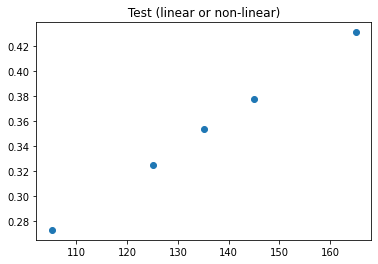

In [4]:
from matplotlib import pyplot as plt # 匯入畫圖函式庫
plt.title(" Test (linear or non-linear) ")
plt.plot(t_u.numpy(), t_c.numpy(), 'o') # 測試後為線性 故可用現在model

print(f" They are linear so we can set up a 線性 model ") 

model線性模型

In [5]:
def model(t_u, w, b): # 設定模型的線性公式 
  return w * t_u + b # 模型設定weight(需要乘以的權重)和b(偏移值) 因為想要找出w和b 得出t_u和t_c的關係

loss function

In [6]:
# loss為表示t_p和t_c的誤差
def loss_fn(t_p, t_c): # 設定預測值為t_p
  squared_diffs = (t_p - t_c)**2 # 以拋物線來看誤差
  return squared_diffs.mean() # 每一次會有一組參數 全部下去平均

初始化 確定模型有在運作

In [7]:
# 初始化 確定模型有在運作(可略)
w = torch.ones(())
b = torch.zeros(())
t_p = model(t_u, w, b)
t_p

tensor([105.1600, 125.1500, 135.1400, 145.0800, 165.0300])

處理train和validation的indice

分成train和validation的數據數目

In [8]:
# 分成train和validation的數據
n_samples = t_u.shape[0] # 共幾筆資料
n_val = int(0.2 * n_samples) # n_val 設為驗證集 數量為sample的0.2倍
# int( )字符串或數字轉換為整數

隨機分成train和validation的indice

In [9]:
# 處理indice
shuffled_indices = torch.randperm(n_samples) # 把sample變成random 會有更好的學習效果
train_indices = shuffled_indices[:-n_val] # train的indice數 => 從前面取 取到倒數幾個(由驗證集的數量決定) 若驗證集為2則取道倒數-2個
val_indices = shuffled_indices[-n_val:] # val的indice數 => 從倒數後幾個取 取到這個list底
train_indices, val_indices

(tensor([3, 1, 0, 2]), tensor([4]))

處理train和validation的數據

In [10]:
train_t_u = t_u[train_indices] # c和t中要被train的
train_t_c = t_c[train_indices]
val_t_u = t_u[val_indices] # c和t中要被驗證val的
val_t_c = t_c[val_indices]
train_t_un = 0.1 * train_t_u # normalize讓效果變好
val_t_un = 0.1 * val_t_u

最佳化資料庫

In [11]:
import torch.optim as optim # 最佳化資料庫

設定最佳化器( params + 學習率 )

In [12]:
params = torch.tensor([1.0, 0.0], requires_grad=True) # 設定初始為w b 為1.0 0.0 後面要對[1.0, 0.0]處理grad
learning_rate = 1 # 設定學習率(SGD學習率可小 Adam學習率可較大)
optimizer = optim.Adam([params], lr=learning_rate) # 設定SGD為最佳化方法 需要對optim.SGD( )設定params(需要訓練的參數)和學習率

training_loop ( 多train和val和optimizer )

In [13]:
def training_loop(n_epochs, optimizer, params, train_t_u, val_t_u, train_t_c, val_t_c): # 設定train_loop 多train和val和optimizer
  for epoch in range(1, n_epochs + 1): # 因為從1開始跌代 故n_epochs要加1 n_epochs為跌代次數

    # train
    train_t_p = model(train_t_u, *params) # model
    train_loss = loss_fn(train_t_p, train_t_c) # loss 

    # val
    with torch.no_grad(): # 關掉grad 因為在驗證階段不用考慮 且它會增加額外cost
      val_t_p = model(val_t_u, *params) # 對於驗證集做一樣的處理 (也可以把w b寫成 *params)
      val_loss = loss_fn(val_t_p, val_t_c)
      assert val_loss.requires_grad == False # (可以不加) 若跑val_loss的時候 發現requires_grad要為false 否則就跳出assert error訊息
    
    # 必要三步驟
    optimizer.zero_grad() # 把 optimizer 中的 grad 設定為 0 防止累加
    train_loss.backward() # 將train_loss逆向反向傳播 並且得出每個train_loss的導數 存到每個*params
    optimizer.step() # step為更新 跌代數據*params
    
    if epoch <= 3 or epoch % 50 == 0: # 只顯示跌代1 2 3 次和 後面每50
      print(f"Epoch {epoch}, Training loss {train_loss.item():.4f}," # training loss 要寫數字的話把該變數{ }起來 前面記得要有f
         f" Validation loss {val_loss.item():.4f}") 
  return params # 回傳w b

訓練開始(最後回傳w b)

In [14]:
# 嘗試用300次跌代訓練
training_loop(
  n_epochs = 300,
  optimizer = optimizer,
  params = params,
  train_t_u = train_t_un, # 有經過normalize
  val_t_u = val_t_un,
  train_t_c = train_t_c,
  val_t_c = val_t_c)

Epoch 1, Training loss 156.5894, Validation loss 258.3092
Epoch 2, Training loss 1.7771, Validation loss 2.0478
Epoch 3, Training loss 89.5733, Validation loss 137.2937
Epoch 50, Training loss 0.4895, Validation loss 1.2071
Epoch 100, Training loss 0.0078, Validation loss 0.0135
Epoch 150, Training loss 0.0030, Validation loss 0.0181
Epoch 200, Training loss 0.0015, Validation loss 0.0087
Epoch 250, Training loss 0.0007, Validation loss 0.0039
Epoch 300, Training loss 0.0003, Validation loss 0.0016


tensor([ 0.0372, -0.1443], requires_grad=True)

畫圖

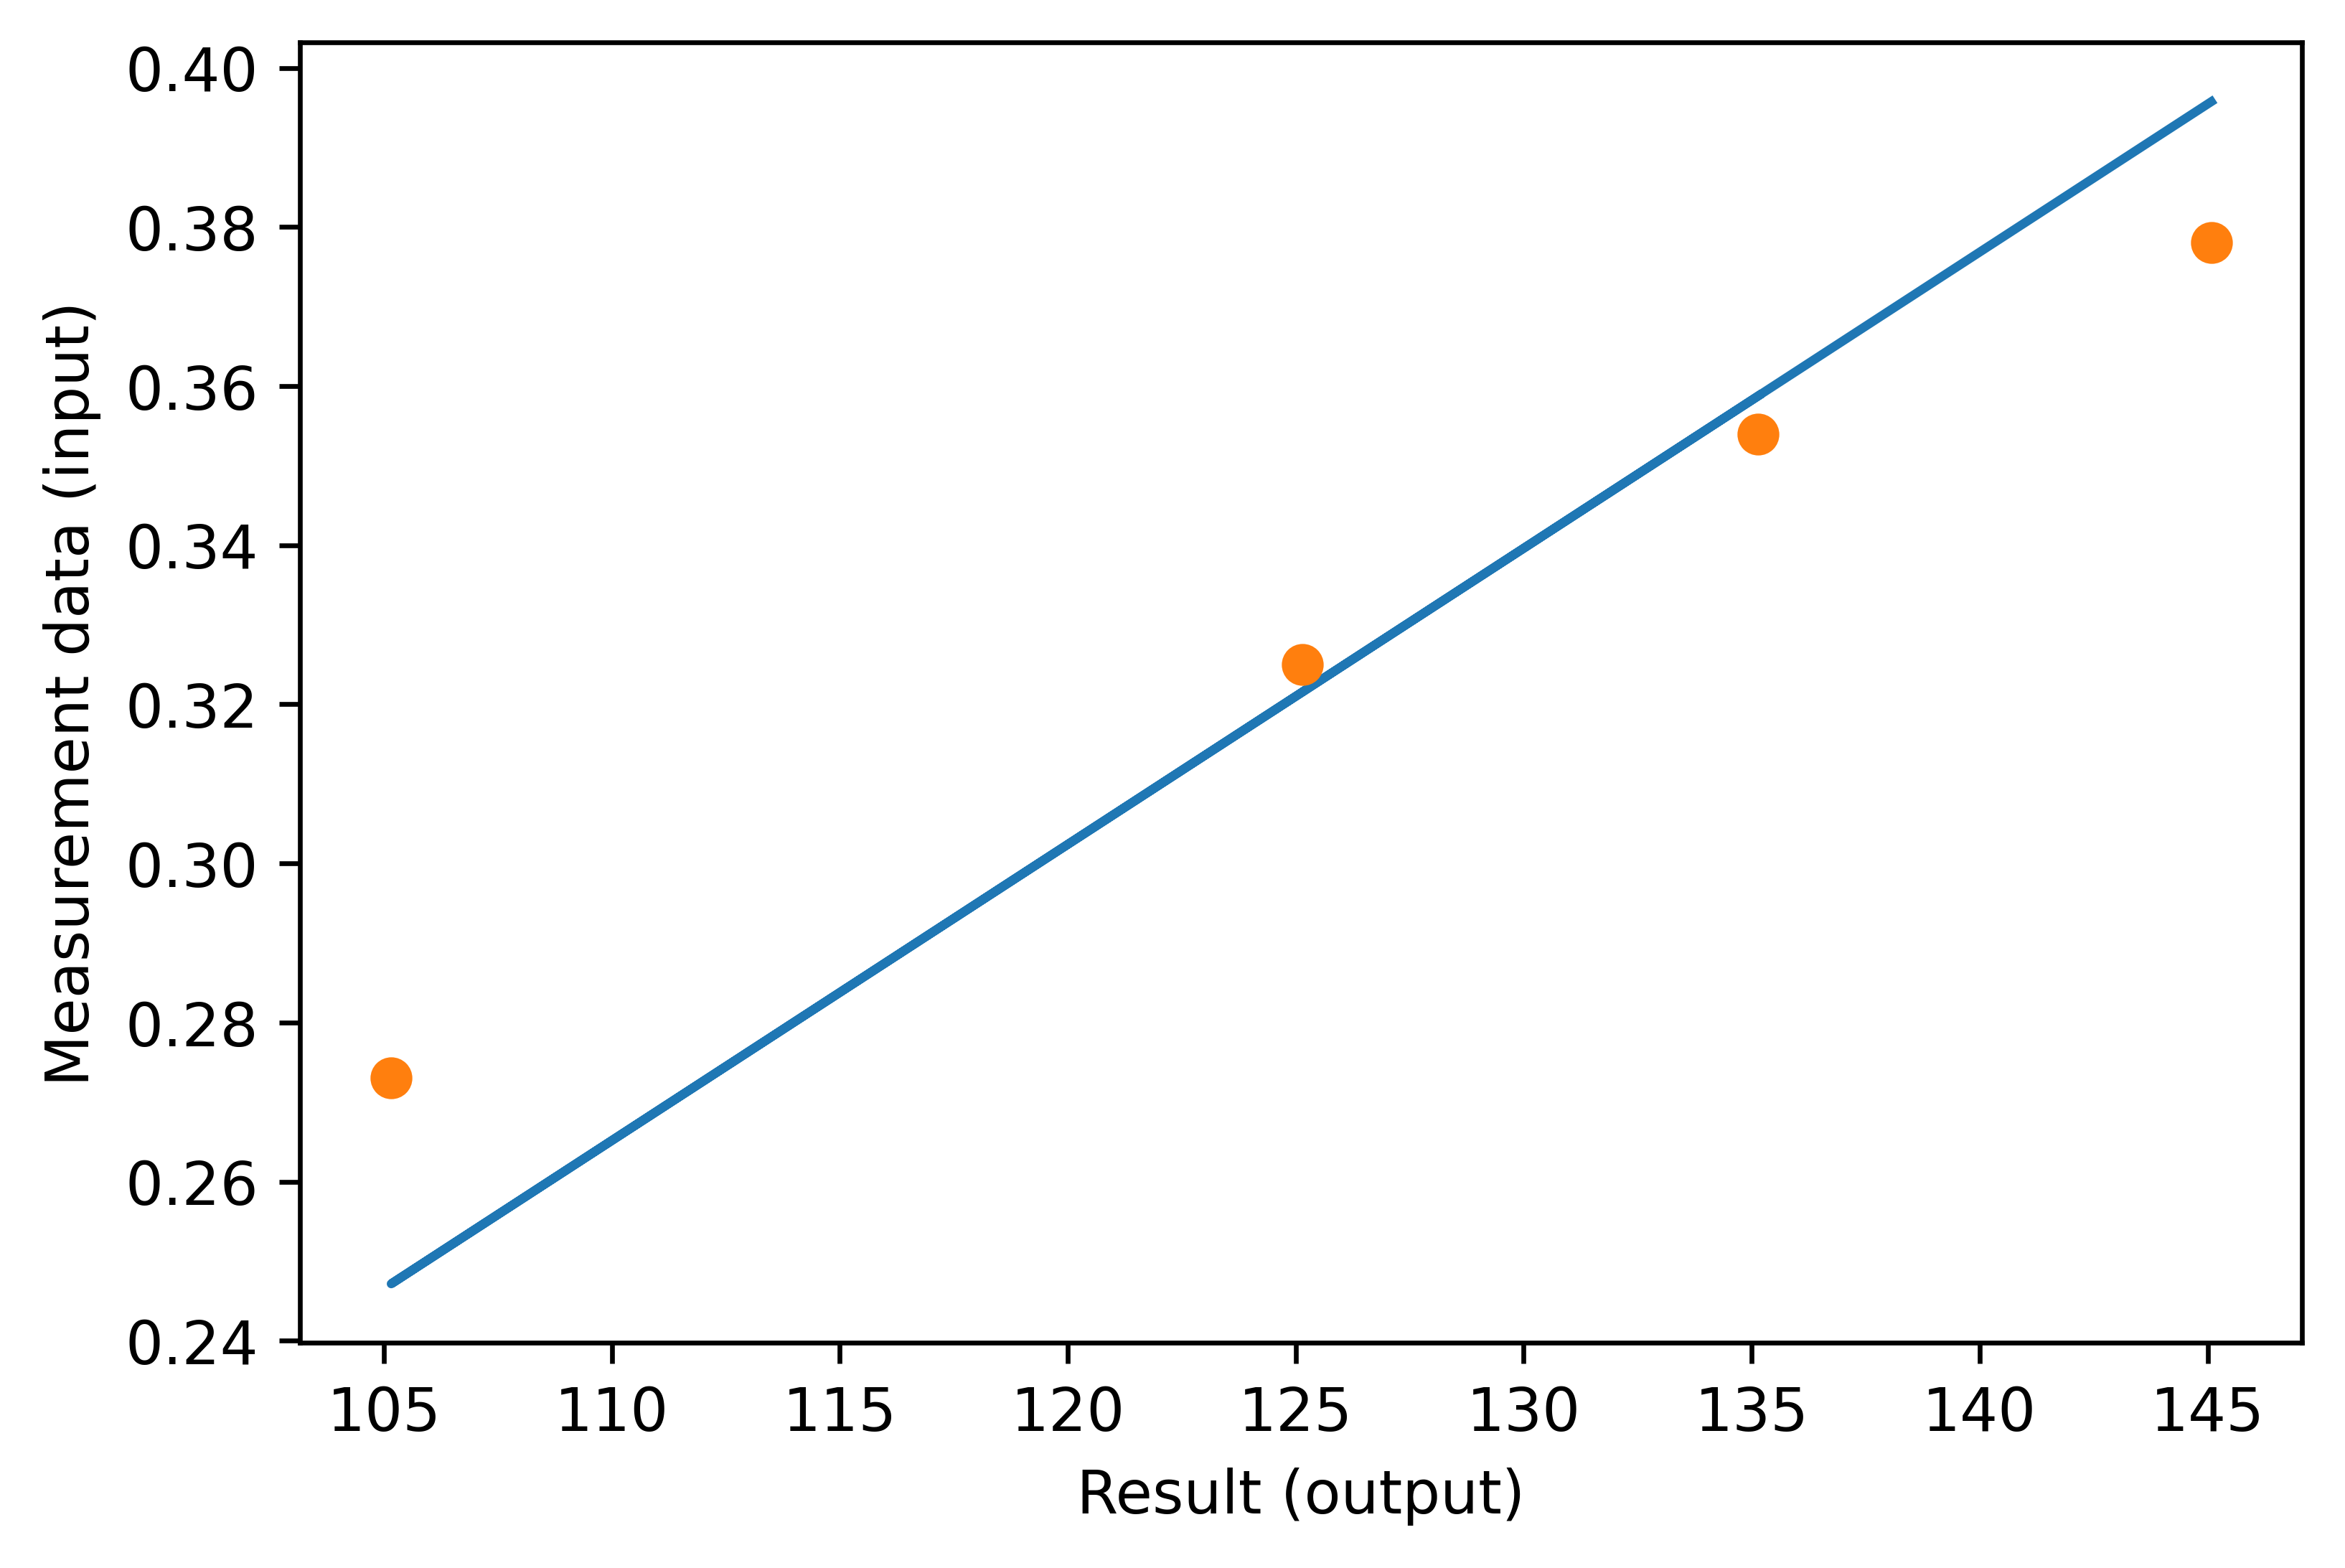

In [15]:
train_t_p = model(train_t_un, *params) # 預測成果
fig = plt.figure(dpi=600) # dpi圖片質量
plt.xlabel(" Result (output) ") # 設定軸標題
plt.ylabel(" Measurement data (input) ")
# detach()為讓圖片定格在一個點 不會因跌代而讓圖片一直變動 但不放也沒關係 因為這題數據不多
plt.plot(train_t_u.numpy(), train_t_p.detach().numpy()) # 訓練結果 t_p轉換為似t_c的型態 線
plt.plot(train_t_u.numpy(), train_t_c.numpy(), 'o') # 原始 'o'為點